<div style="display: flex; align-items: center;">
    <img src="https://github.com/nagelt/Teaching_Scripts/raw/9d9e29ecca4b04eaf7397938eacbf116d37ddc93/Images/TUBAF_Logo_blau.png"
         width="500" height="auto" style="margin-right: 100px;" />
    <div>
        <p><strong>Prof. Dr. Thomas Nagel</strong></p>
        <p>
            Chair of Soil Mechanics and Foundation Engineering<br>
            Geotechnical Institute<br>
            Technische Universität Bergakademie Freiberg.
        </p>
        <p>
            <a href="https://tu-freiberg.de/en/soilmechanics">
                https://tu-freiberg.de/en/soilmechanics
            </a>
        </p>
    </div>
</div>

<div style="display: flex; align-items: center;">
    <p style="margin-top: 1em;">
        To activate the <strong>interactive features</strong> when in nbviewer mode, click on &quot;Execute on Binder&quot;
        <img src="https://mybinder.org/static/favicon.ico"
             alt="Binder"
             style="height: 1.1em; vertical-align: middle; margin: 0 6px;">
        on the top right. Then, click on Run → Run All Cells.
    </p>
</div>


# Exercise on Earth pressure and the Newton-Raphson scheme

![Erddruck.png](https://raw.githubusercontent.com/nagelt/Teaching_Scripts/master/Images/Erddruck.png)

## Geometry 
Let the retaining wall have a vertical height $H$ and the origin be placed at the bottom of the slip surface which has length $L$. Then, the problem is characterized by the following points in the $x-z$ plane:

* Origin: $O = [0,0]$
* Top left: $A = [-H \tan \alpha, H]$
* Top right: $B = [L\cos \vartheta, L \sin \vartheta]$

The length of the slip surface can be found via the following trigonometric relation:

\begin{align}
    L \sin \vartheta &= (L \cos \vartheta + H \tan\alpha) \tan \beta
\end{align}

Thus we arrive at

\begin{align}
    L &= \frac{H(1 + \tan \alpha \tan \beta)}{\sin \vartheta - \cos \vartheta \tan \beta}
\end{align}

The area of the triangle (i.e. the volume of the slip body per meter) can also be calculated. We use Gauß' equation for that:

$$
    A = \frac{1}{2} \left| (x_2 y_3 - x_3 y_2) - (x_1 y_3 - x_3 y_1) + (x_1 y_2 - x_2 y_1) \right|
$$

Let Python do the math for us ...

In [2]:
import numpy as np #numerical methods
#import sympy as sp #symbolic operations
import matplotlib.pyplot as plt #plotting
import sympy as sp
sp.init_printing(use_latex='mathjax') #makes sympy output look nice

from ipywidgets import widgets
from ipywidgets import interact

#Some plot settings
import plot_functions.plot_settings
%run plot_functions/earth_pressure_plots.ipynb

We first define our geometrical properties:

In [3]:
H,alpha,beta,theta = sp.symbols('H alpha beta vartheta')

In [4]:
L = H*(1+sp.tan(alpha)*sp.tan(beta))/(sp.sin(theta) - sp.cos(theta) * sp.tan(beta))
L

       H⋅(tan(α)⋅tan(β) + 1)        
────────────────────────────────────
sin(vartheta) - cos(vartheta)⋅tan(β)

We now define the function that calculates the area of the triangle:

In [5]:
def triangle_area_Gauss(A,B,C):
    term1 = (B[0]*C[1] - C[0] * B[1])
    term2 = (A[0]*C[1] - C[0] * A[1])
    term3 = (A[0]*B[1] - B[0] * A[1])
    return -(term1 - term2 + term3)/2

The points we defined above can now be inserted into this equation:

In [6]:
PO = [0,0]
PA = [- H * sp.tan(alpha), H]
PB = [L * sp.cos(theta), L*sp.sin(theta)]
A = triangle_area_Gauss(PO,PA,PB).simplify()
A

 2                                                           
H ⋅(sin(vartheta)⋅tan(α) + cos(vartheta))⋅(tan(α)⋅tan(β) + 1)
─────────────────────────────────────────────────────────────
          2⋅(sin(vartheta) - cos(vartheta)⋅tan(β))           

.Thus, the area of our triangle is given as:

$$
    A = \frac{H^2 (\sin \vartheta \tan \alpha + \cos \vartheta) (\tan \alpha \tan \beta + 1)}{2(\sin \vartheta - \cos \vartheta \tan \beta)}
$$

Now we can write the force balance. For that purpose, we introduce the material's specific weight $\gamma$, friction angle $\varphi$ and the wall friction angle $\delta_\text{a}$ as well as the cohesion $c$.

In [7]:
c, delta, phi, gamma = sp.symbols('c delta_a varphi gamma')

We can now calculate the downward force due to gravity as well as the cohesive force along the slip surface. The active earth pressure force $E_\text{a}$ and the reaction force $Q$ in the slip line are introduced as unknowns:

In [8]:
Ea, Q, G, C = sp.symbols('E_a Q G C')

We now write the vertical and horizontal equilibrium conditions:

\begin{align}
    \text{horizontal:}\quad  0 &= C \cos\vartheta - Q \sin (\vartheta - \varphi) + E_\text{a} \cos (\alpha + \delta_\text{a})
    \
    \text{vertikal:}\quad  0 &= C \sin\vartheta + Q \cos (\vartheta - \varphi) + E_\text{a} \sin (\alpha + \delta_\text{a}) - G
\end{align}

In [9]:
Fh = sp.Eq(C * sp.cos(theta) - Q * sp.sin(theta - phi) + Ea * sp.cos(alpha + delta),0)
Fv = sp.Eq(C * sp.sin(theta) + Q * sp.cos(theta - phi) + Ea * sp.sin(alpha + delta) - G,0)

In [10]:
Fh

C⋅cos(vartheta) + Eₐ⋅cos(α + δₐ) + Q⋅sin(varphi - vartheta) = 0

In [11]:
Fv

C⋅sin(vartheta) + Eₐ⋅sin(α + δₐ) - G + Q⋅cos(varphi - vartheta) = 0

In [12]:
result = sp.solve([Fh,Fv],(Ea,Q))

In [13]:
result.get(Q).simplify()

C⋅sin(α + δₐ - vartheta) + G⋅cos(α + δₐ)
────────────────────────────────────────
    cos(α + δₐ + varphi - vartheta)     

.... for $Q$.

In [14]:
result.get(Ea).simplify()

-(C⋅cos(varphi) + G⋅sin(varphi - vartheta)) 
────────────────────────────────────────────
      cos(α + δₐ + varphi - vartheta)       

... for $E_\text{a}$. If we substitute the result for $G$, we start to see the issue ....

In [15]:
result.get(Ea).subs(G,A*gamma).simplify()

                                                         2                     ↪
                                                        H ⋅γ⋅(sin(vartheta)⋅ta ↪
-C⋅(sin(vartheta) - cos(vartheta)⋅tan(β))⋅cos(varphi) - ────────────────────── ↪
                                                                               ↪
────────────────────────────────────────────────────────────────────────────── ↪
                                    (sin(vartheta) - cos(vartheta)⋅tan(β))⋅cos ↪

↪                                                                 
↪ n(α) + cos(vartheta))⋅(tan(α)⋅tan(β) + 1)⋅sin(varphi - vartheta)
↪ ────────────────────────────────────────────────────────────────
↪                     2                                           
↪ ────────────────────────────────────────────────────────────────
↪ (α + δₐ + varphi - vartheta)                                    

Now we would have to find the maximum with respect to $\vartheta$ in order to identify the active earth pressure and the critical slip angle $\vartheta_\text{a}$. The equations get very complex and we decide to go for a numerical solution.

First, we define the basic geometry of our problem:

In [16]:
alpha = 10. * np.pi/180.
beta = 20. * np.pi/180.
H = 4. #m

In [17]:
def slip_length(theta):
    L = H * (1 + np.tan(alpha) * np.tan(beta))/(np.sin(theta) - np.cos(theta)*np.tan(beta))
    return L

In [18]:
def area(theta):
    term1 = (np.tan(alpha)*np.tan(beta) + 1) * (np.sin(theta)*np.tan(alpha) + np.cos(theta))
    term2 = np.sin(theta) - np.cos(theta) * np.tan(beta)
    return H*H * term1 / term2 / 2

Now we define the material properties and the interaction with the wall:

In [19]:
gamma = 19.e3 #N/m³
phi = np.deg2rad(30.)
c = 10.e3 #N/m²
delta = np.deg2rad(10.)

In [20]:
def cohesive_force(theta):
    return c * slip_length(theta)

In [21]:
def weight(theta):
    return gamma*area(theta)

Now we have all the ingredients to calculate the active earth pressure given by the equation above:

In [22]:
def Ea(theta):
    term1 = weight(theta) * np.sin(theta-phi) - cohesive_force(theta) * np.cos(phi)
    term2 = np.cos(alpha+delta+phi-theta)
    return term1/term2

Let's take a look at the result:

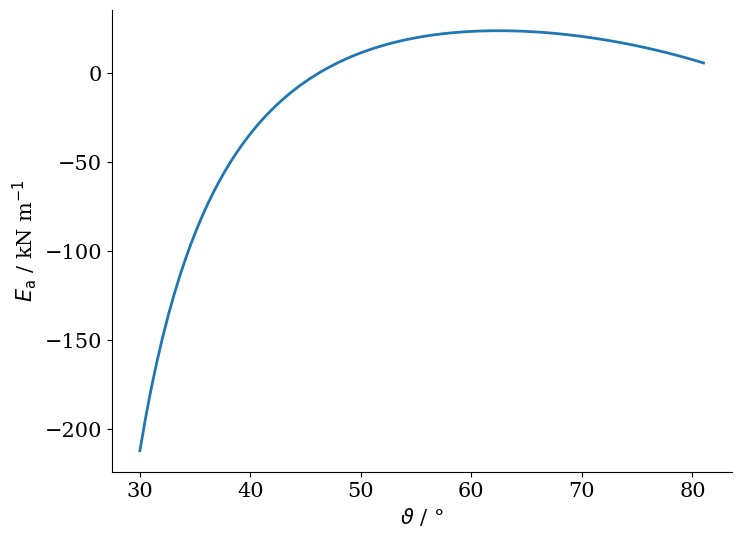

In [23]:
thetas = np.linspace(np.pi/6,np.pi/2*0.9,100)
plt.plot(thetas*180/np.pi,Ea(thetas)/1e3)
plt.xlabel(r'$\vartheta$ / °')
plt.ylabel(r'$E_\mathrm{a}$ / kN m$^{-1}$');

The active earth pressure is found at the peak of this curve. In other words we need to identify

$$
    \frac{\partial E_\text{a}}{\partial \vartheta} = 0
$$

and 

$$
    \vartheta_\text{a} = \underset{\vartheta \in [0,\pi/2]}{\text{arg max }}E_\text{a}
$$

As we saw above, this is cumbersome analytically. However, we can find the solution numerically in an iterative manner.

As we have

$$
    \left. \frac{\partial E_\text{a}}{\partial \vartheta} \right|_{\vartheta_\text{a}} = 0
$$

we find for other angles the following residual:

$$
    r(\vartheta) = \frac{\partial E_\text{a}}{\partial \vartheta} \neq 0
$$

to which we seek the solution

$$
    r(\vartheta_\text{a}) = 0
$$

Since we don't want to go through the trouble to determine the first derivative of $E_\text{a}$ with respect to $\vartheta$ analytically, we do so numerically by numerical differentiation using a central finite difference scheme:

$$
    \frac{\partial E_\text{a}}{\partial \vartheta} \approx \frac{E_\text{a}(\vartheta + \epsilon) - E_\text{a}(\vartheta - \epsilon)}{2\epsilon}
    \quad
    \text{with}
    \quad \epsilon \ll 1,\ \epsilon > 0
$$

In [24]:
def dEa_dtheta(theta,eps=1.e-4):
    return (Ea(theta+eps) - Ea(theta-eps))/(2.*eps)

The former function defines the slope and equals our residual:

In [25]:
def residual(theta):
    return dEa_dtheta(theta)

Now, we use Newton's method to find the solution to the non-linear equation $r(\vartheta) = 0$. We depart from a Taylor series expansion to first order around an initial guess $\vartheta_0$:

$$
    r(\vartheta) \approx r(\vartheta_0) + \left. \frac{\partial r}{\partial \vartheta} \right|_{\vartheta_0} \Delta \vartheta \overset{!}{=} 0
    \quad
    \text{with}
    \quad
    \Delta \vartheta = \vartheta - \vartheta_0
$$

We obtain the next guess for $\vartheta$ by rearranging:

$$
    \vartheta = \vartheta_0 - \left( \left. \frac{\partial r}{\partial \vartheta} \right|_{\vartheta_0} \right)^{-1} r(\vartheta_0)
$$

As we linearized the non-linear function, the new guess is likely still not the solution we seek. Hence, we iterate:

$$
    \vartheta_{i+1} = \vartheta_i - \left( \left. \frac{\partial r}{\partial \vartheta} \right|_{\vartheta_i} \right)^{-1} r(\vartheta_i)
$$

We terminate the solution once $\vartheta$ no longer changes, e.g. once

$$
    | \vartheta_{i+1} - \vartheta_i | < \epsilon_\text{tol}
$$

Another criterion, which is more direct, is to determine when the residual is close enough to zero:

$$
    | r(\vartheta_{i+1}) | < \epsilon_\text{tol}
$$

In order to code this algorithm, we need the first derivative of the residual with respect to $\vartheta$ (this is actually the second derivative of $E_a$):

In [26]:
def dr_dtheta(theta,eps=1.e-4):
    return (residual(theta+eps) - residual(theta-eps))/(2.*eps)

We now code the algorithm and give it a starting guess $\vartheta_0$ and a termination tolerance $\epsilon_\text{tol}$:

In [27]:
def find_theta(theta_0=np.pi/6, tol=1.e-6):
    theta = theta_0
    iteration_counter = 0
    res_vec = np.array([])
    theta_vec = np.array([theta])
    while (np.abs(residual(theta)) > tol and iteration_counter < 100):
        res_vec = np.append(res_vec,residual(theta))
        theta -= residual(theta) / dr_dtheta(theta)
        theta_vec = np.append(theta_vec,theta)
        iteration_counter += 1
    return theta, iteration_counter, res_vec, theta_vec

Running this algorithm will give us the solution we seek.

In [28]:
theta_a, it, res, sols = find_theta()

In [29]:
print("The slip angle of %.2f ° was found after %i iterations. The corresponding earth pressure is %.2f MN/m." 
      %(np.rad2deg(theta_a),it,Ea(theta_a)/1.e6))

The slip angle of 62.43 ° was found after 8 iterations. The corresponding earth pressure is 0.02 MN/m.


The result was found after several iterations. We may lower this number by improving our starting guess. For example, we could use the classical solution

$$
    \vartheta_0 = \frac{\pi}{4} + \frac{\varphi}{2}
$$

In [30]:
theta_a, it, res, sols = find_theta(np.pi/4 + phi/2)
print("The slip angle of %.2f ° was found after %i iterations. The corresponding earth pressure is %.2f MN/m." 
      %(np.rad2deg(theta_a),it,Ea(theta_a)/1.e6))

The slip angle of 62.43 ° was found after 4 iterations. The corresponding earth pressure is 0.02 MN/m.


We arrive at the same result, albeit in fewer iterations. We can check this result graphically:

In [38]:
#%run plot_functions/earth_pressure_plots.ipynb
plot_iterative_interactive()

interactive(children=(BoundedFloatText(value=45.0, description='$\\vartheta_0 / °$', max=90.0, min=10.0), Outp…

We see that the Newton algorithm reaches quadratic convergence. The convergence order $q$ was determined by comparing the reduction of the residual in two subsequent iterations:

$$
    \left( \frac{x_n}{x_{n-1}} \right)^q =  \frac{x_{n+1}}{x_{n}}
$$

If we choose an initial guess that's outside of the convergence region for the Newton scheme, we may not converge at all or to the wrong solution.

We can also compare this result to the one from DIN4085, for example:

$$
    \vartheta_\text{ag} = \varphi + \text{arctan} \left[ \frac{\cos(\varphi - \alpha)}{\sin(\varphi - \alpha) + \sqrt{ \displaystyle \frac{\sin(\varphi + \delta_\text{a}) \cos (\alpha - \beta)}{\sin(\varphi - \beta) \cos (\alpha + \delta_\text{a})} } }  \right]
$$

In [32]:
def theta_ag_norm(phi,alpha,delta,beta):
    t1 = np.cos(phi - alpha)
    t2 = np.sin(phi - alpha) + np.sqrt((np.sin(phi + delta)*np.cos(alpha-beta))/(np.sin(phi-beta)*np.cos(alpha+delta)))
    return (phi + np.arctan(t1/t2))*180/np.pi

In [33]:
print("For the non-cohesive case the norm gives us %.2f °." %theta_ag_norm(phi,alpha,delta,beta))

For the non-cohesive case the norm gives us 52.12 °.


## Tasks:

* Check whether you get the same result by setting $c=0$.
* Determine why some starting guesses don't work.
* Play with the parameters and learn something.

In [34]:
plot_interactive_earth_pressure()

interactive(children=(IntSlider(value=10, description='$c$ / kN m$^{-2}$:', max=50, step=5), IntSlider(value=3…

![Erddruck.png](https://raw.githubusercontent.com/nagelt/Teaching_Scripts/master/Images/Erddruck.png)